In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from sklearn.metrics import auc
from statistics import mean
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
import sys
pd.set_option('display.max_columns', None)


In [2]:
root_dir = os.path.abspath(os.path.join(os.path.dirname('see_all_expewriments.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [3]:
def calculate_auc_avg(tickers, predictions, true_values):
    predictions = predictions.sort_values(by='fecha')
    true_values = true_values.sort_values(by='fecha')
    
    
    # renombro las columnas
    column_names = {}
    for column in predictions.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_pred'
    
    predictions = predictions.rename(columns=column_names)
    
    column_names = {}
    for column in true_values.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_true'
    
    true_values = true_values.rename(columns=column_names)
    performance = pd.concat(
        [
            predictions,
            true_values
        ], axis=1, join="inner"
    )
    
    auc_list = []
    for ticker in tickers:
        y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
        y_pred = performance[performance[f'{ticker}_pred'].notna()][f'{ticker}_pred']
        
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        auc_list.append(precision)

    return mean(auc_list)

In [4]:
def max_drawdown(serie):
    max_valor_acumulado = serie[0]
    max_dd = 0

    for valor_actual in serie[1:]:
        if valor_actual > max_valor_acumulado:
            max_valor_acumulado = valor_actual
        else:
            dd = (max_valor_acumulado - valor_actual) / max_valor_acumulado
            if dd > max_dd:
                max_dd = dd

    return max_dd

In [5]:
def calculate_avg_returns_perc(orders):
    orders_per_month = orders[['close_time','profit', 'comment']].copy()
    orders_per_month['close_time'] = pd.to_datetime(orders_per_month['close_time'])
    orders_per_month['year'] = orders_per_month['close_time'].dt.year
    orders_per_month['month'] = orders_per_month['close_time'].dt.month
    
    orders_per_month_gb = orders_per_month.groupby(by=['year','month']).agg(
        profit_sum=('profit', 'sum'),
    ).reset_index()
    
    orders_per_month_gb = pd.concat([
        pd.DataFrame({'year':[2023], 'month':[0],'amount_ops':[0], 'profit_sum':[initial_wallet_value]}), 
        orders_per_month_gb
    ])
    
    orders_per_month_gb['profit_cumsum'] = orders_per_month_gb['profit_sum'].cumsum()
    
    orders_per_month_gb['perc_change'] = ((orders_per_month_gb['profit_cumsum'] - orders_per_month_gb['profit_cumsum'].shift(1)) / orders_per_month_gb['profit_cumsum'].shift(1))
    
    return orders_per_month_gb.perc_change.mean(), orders_per_month_gb.perc_change.std()

In [6]:
with open('configs/parameters.yml', 'r') as archivo:
    parameters = yaml.safe_load(archivo)

In [7]:
eta = 0
for param, value in parameters.items():
    if eta == 0:
        eta += len(value)
    else:
        eta *= len(value)

eta = (eta * 10) / 60

print(f'el tiempo estimado de los experimentos es de {round(eta, 2)} horas')

el tiempo estimado de los experimentos es de 5.33 horas


In [8]:
with open('configs/project_config.yml', 'r') as archivo:
    config = yaml.safe_load(archivo)
tickers = config["tickers"] 
tickers

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCAD', 'AUDUSD', 'USDCHF']

In [9]:
results_dict = {}
initial_wallet_value = config['start_money']
from pathlib import Path

# iteration = '3'
# experiments_path = f'./backbone/data/backtest/experiments/{iteration}'
# paths = sorted(Path(experiments_path).iterdir(), key=os.path.getmtime)
# paths = [p.__str__().split('\\')[-1] for p in paths]


paths = os.listdir('./backbone/data/backtest/experiments')
experiments_path = f'./backbone/data/backtest/experiments'

# paths = [
#     '0/Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseTime_True-TS_True_opt',
#     '0/Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_3-CloseTime_True-TS_False_opt',
#     '1/Mode_train-Model_gradient_boosting-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_3-CloseTime_True-TS_True_opt',
#     '2/Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseTime_True-TS_True_opt',
#     '4/Mode_train-Model_None-TrainWw_11520-TrainPd_24-TradStgy_only_strategy-PerFwTg_8-SL_15-RR_2-CloseTime_True-TS_False_opt'
# ]

for path in paths:
    if not path.endswith('.csv'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join(experiments_path, path, 'wallet.csv'))

            final_wallet_value = wallet.tail(1).iloc[0]['wallet']
            results_dict[path]['wallet'] = ((final_wallet_value - initial_wallet_value) / initial_wallet_value) * 100
            results_dict[path]['max_drawdown'] = max_drawdown(wallet['wallet'])
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join(experiments_path, path, 'orders.csv'))
    
            mean_returns, std_returns = calculate_avg_returns_perc(orders)
            results_dict[path]['mean_perc_returns'] = mean_returns
            results_dict[path]['std_perc_returns'] = std_returns
            
            
            results_dict[path]['buys'] = orders[orders['open_time'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_time'].notna()].shape[0]
           
            # avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            # results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] >= 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] < 0].shape[0]
    
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 
    
            
            # Asegurarse de que la columna 'Date' esté en formato de fecha
            orders['date'] = pd.to_datetime(orders['close_time'])
            orders['date_rounded'] = orders['date'].dt.floor('D')
            daily_profits = orders.groupby('date_rounded')['profit'].sum()
            daily_returns = daily_profits.pct_change()
            tasa_libre_riesgo_anual = 0.02
            tasa_libre_riesgo_diaria = (1 + tasa_libre_riesgo_anual) ** (1/252) - 1
            exceso_retorno = daily_returns - tasa_libre_riesgo_diaria
            sharpe_ratio_anualizado = (exceso_retorno.mean() / exceso_retorno.std()) * np.sqrt(252)
    
            results_dict[path]['sharpe_ratio'] = sharpe_ratio_anualizado
        
            results_dict[path]['winning_rate'] = orders[orders['profit'] >= 0]['profit'].mean() / (-1 * orders[orders['profit'] < 0]['profit'].mean())
            
            results_dict[path]['recover_factor'] = orders[orders['profit'] >= 0]['profit'].sum() / (-1 * orders[orders['profit'] < 0]['profit'].sum())
    
            results_dict[path]['stability_index'] = orders['profit'].std() / orders['profit'].mean()
    
            for ticker in tickers:
                results_dict[path][f'profits_in_{ticker}'] = orders[orders['ticker'] == ticker]['profit'].sum()

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0
        try:
            train_results = pd.read_csv(os.path.join(experiments_path, path, 'trainres.csv')).dropna()
            results_dict[path]['avg_train_precision'] = train_results['precision'].mean()
            results_dict[path]['avg_train_recall'] = train_results['recall'].mean()
            results_dict[path]['avg_train_f1'] = train_results['f1'].mean()
        except:
            results_dict[path]['avg_train_precision'] = 0
            results_dict[path]['avg_train_recall'] = 0
            results_dict[path]['avg_train_f1'] = 0
            
        try:
            predictions = pd.read_csv(os.path.join(experiments_path, path, 'test_res.csv')).dropna()
    
            results_dict[path]['avg_test_precision'] = precision_score(predictions.y_true, predictions.y_pred, average='weighted')
            results_dict[path]['avg_test_recall'] = recall_score(predictions.y_true, predictions.y_pred, average='weighted')
            results_dict[path]['avg_test_f1'] = f1_score(predictions.y_true, predictions.y_pred, average='weighted')
        except:
            results_dict[path]['avg_test_precision'] = 0
            results_dict[path]['avg_test_recall'] = 0
            results_dict[path]['avg_test_f1'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')

Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_2-CloseTime_True-TS_False
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_2-CloseTime_True-TS_True
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_3-CloseTime_True-TS_False
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_3-CloseTime_True-TS_True
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_15-RR_2-CloseTime_True-TS_False
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_15-RR_2-CloseTime_True-TS_True
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_15-RR_3-CloseTime_True-TS_False
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-P

In [10]:
beta = 0.05
eurusd = pd.read_csv('./backbone/data/backtest/symbols/EURUSD.csv')
results['buy_ratio'] = results['buys'] / (eurusd.Date.nunique() * len(tickers))
results['operation_ratio_2'] = ((1 + beta**2) * results['operation_ratio'] * results['buy_ratio']) / (beta * results['operation_ratio'] + results['buy_ratio'])

In [11]:
positive_results = results[
    [
        'operation_ratio_2',
        'operation_ratio', 
        'buy_ratio',
        'mean_perc_returns',
        'std_perc_returns',
        'winning_rate',
        'recover_factor',
        'sharpe_ratio',
        'stability_index',
        'max_drawdown',
        'good_operations',
        'bad_operations',
        'wallet',
        # 'profits_in_EURUSD',
        # 'profits_in_GBPUSD', 
        # # 'profits_in_USDJPY', 
        # 'profits_in_USDCAD',
        # 'profits_in_AUDUSD', 
        # 'profits_in_USDCHF',
        'avg_train_precision',
        'avg_train_recall',
        'avg_train_f1',
        'avg_test_precision',
        'avg_test_recall',
        'avg_test_f1',
    ]
].sort_values(by='wallet', ascending=False)

# positive_results = positive_results[
#     (results['wallet']>5000)
#     & (results['max_drawdown']<=0.1)
# ].sort_values(by='sharpe_ratio', ascending=False)


positive_results.head(10)

,operation_ratio_2,operation_ratio,buy_ratio,mean_perc_returns,std_perc_returns,winning_rate,recover_factor,sharpe_ratio,stability_index,max_drawdown,good_operations,bad_operations,wallet,avg_train_precision,avg_train_recall,avg_train_f1,avg_test_precision,avg_test_recall,avg_test_f1
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_2-CloseTime_True-TS_False,0.044086,0.430622,0.002449,0.038543,0.048699,1.825355,1.380521,1.354830,6.721125,0.095532,90,119,55.57584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_12-SL_15-RR_3-CloseTime_True-TS_False,0.043823,0.406699,0.002449,0.039683,0.073921,1.989675,1.363890,-2.100275,7.658868,0.157326,85,124,55.14983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_3-CloseTime_True-TS_False,0.043204,0.358852,0.002449,0.035883,0.061672,2.295026,1.284529,-0.962490,9.340097,0.142588,75,134,49.68801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_2-CloseTime_True-TS_True,0.044086,0.430622,0.002449,0.030125,0.034127,1.792881,1.355960,1.343973,7.563571,0.090032,90,119,41.92228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_8-SL_10-RR_3-CloseTime_True-TS_False,0.043651,0.392344,0.002449,0.030804,0.055680,1.953750,1.261476,-1.656114,10.202506,0.117276,82,127,41.69406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_15-RR_3-CloseTime_True-TS_False,0.020456,0.472527,0.001066,0.029822,0.032061,1.931017,1.729870,-1.964314,4.296609,0.059258,43,48,41.52412,0.824561,0.824561,0.824561,0.561038,0.516746,0.532078
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_8-SL_15-RR_3-CloseTime_True-TS_False,0.044370,0.459330,0.002449,0.030292,0.055871,1.567954,1.332067,-1.715070,8.415140,0.124800,96,113,40.78155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_12-SL_15-RR_3-CloseTime_True-TS_True,0.044414,0.464115,0.002449,0.029760,0.053226,1.608577,1.393142,-0.658788,7.883683,0.092672,97,112,40.11098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_12-SL_15-RR_2-CloseTime_True-TS_True,0.044457,0.468900,0.002449,0.029456,0.047184,1.587756,1.401802,0.846222,7.174495,0.087839,98,111,40.04538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mode_train-Model_None-TrainWw_0-TrainPd_0-TradStgy_bband_sell_stgy-PerFwTg_8-SL_15-RR_2-CloseTime_True-TS_False,0.044541,0.478469,0.002449,0.028514,0.043581,1.445442,1.326094,-0.248618,8.036723,0.112191,100,109,38.76452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


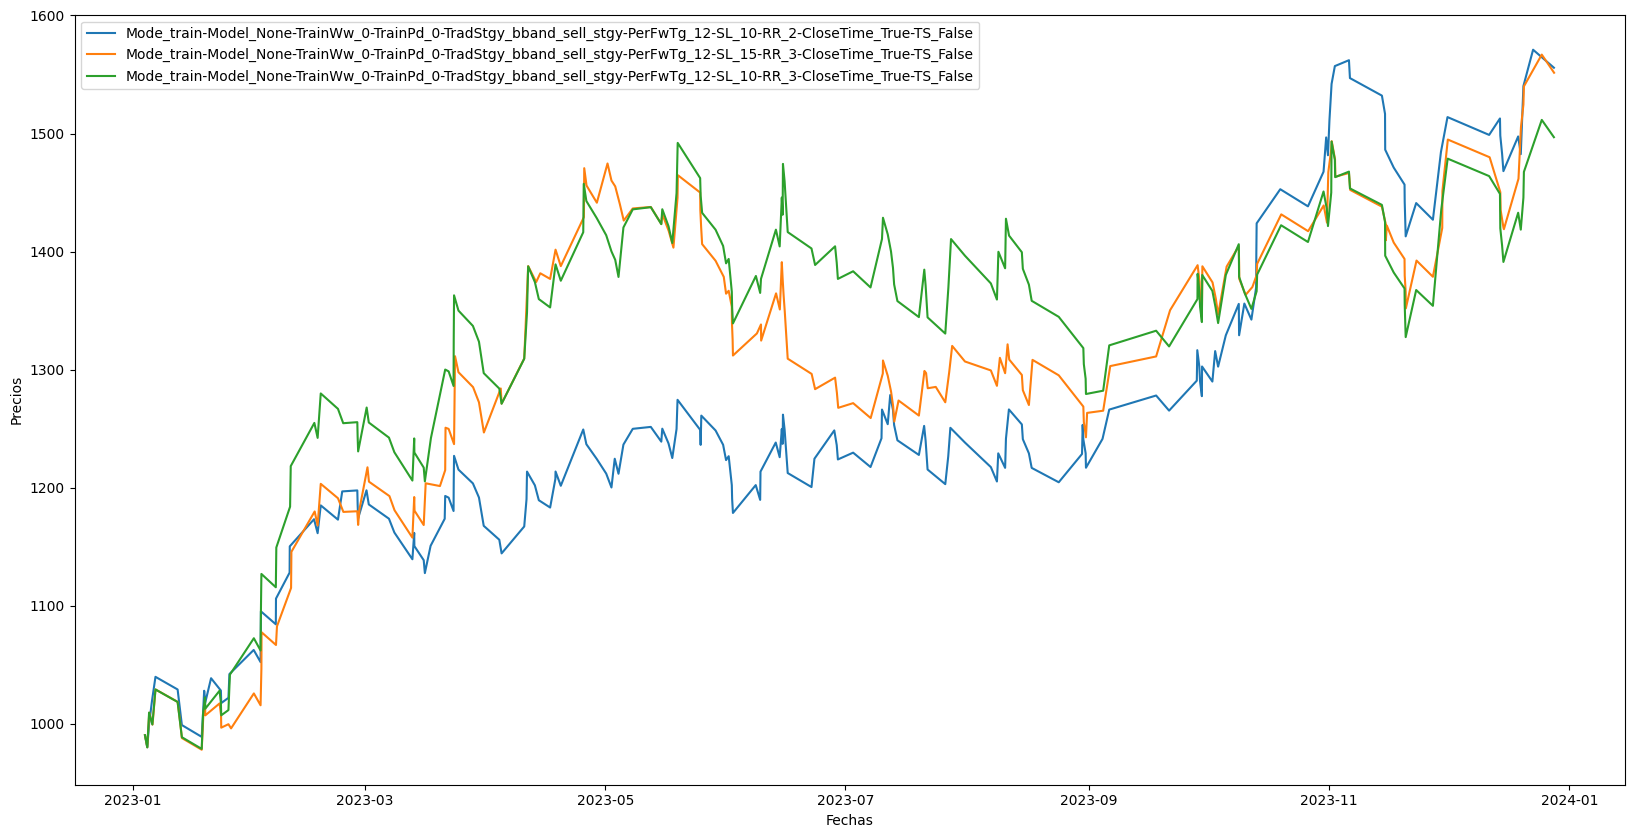

In [12]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

filter_results = positive_results.iloc[0:3]
fig, ax = plt.subplots(figsize=(20, 10))
for path in filter_results.index:

    wallet = pd.read_csv(os.path.join(experiments_path, path, 'wallet.csv'))

    # Datos de ejemplo
    x_wallet = pd.to_datetime(wallet['date'])
    y_wallet = wallet['wallet']  # Datos para la línea
    
    # Crear una figura y ejes
    
    # Agregar la línea
    ax.plot(x_wallet, y_wallet, label=f'{path}')
    
# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()
    
    # Mostrar el gráfico
    # print(path)
plt.show()
    # time.sleep(5)
    # clear_output(wait=True)

In [13]:
import re

In [14]:
filter_results = results[results['wallet']>0]


In [15]:
filter_results = filter_results.reset_index().rename(columns={'index':'experiment'})

In [16]:
filter_results['model'] = filter_results['experiment'].apply(lambda x: re.search(r'-Model_(.*?)-', x).group(1))
filter_results['window'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainWw_(.*?)-', x).group(1))
filter_results['train_period'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainPd_(.*?)-', x).group(1))
filter_results['strategy'] = filter_results['experiment'].apply(lambda x: re.search(r'-TradStgy_(.*?)-', x).group(1))
filter_results['periods_forward_target'] = filter_results['experiment'].apply(lambda x: re.search(r'-PerFwTg_(.*?)-', x).group(1))
filter_results['sl'] = filter_results['experiment'].apply(lambda x: re.search(r'-SL_(.*?)-', x).group(1))
filter_results['rr'] = filter_results['experiment'].apply(lambda x: re.search(r'-RR_(.*?)-', x).group(1))
filter_results['trailing_stop'] = filter_results['experiment'].apply(lambda x: x.split('TS_')[1])
# filter_results['use_days_to_close'] = filter_results['experiment'].apply(lambda x: x.split('UseDaysClose_')[1])

In [17]:
filter_results[
    (filter_results.model=='gradient_boosting')
    &(filter_results.strategy=='bband_sell_stgy')
    &(filter_results.sl=='10')
    &(filter_results.periods_forward_target=='12')
    &(filter_results.trailing_stop=='True')
]

,experiment,wallet,max_drawdown,mean_perc_returns,std_perc_returns,buys,sells,good_operations,bad_operations,operation_ratio,sharpe_ratio,winning_rate,recover_factor,stability_index,profits_in_EURUSD,profits_in_GBPUSD,profits_in_USDJPY,profits_in_USDCAD,profits_in_AUDUSD,profits_in_USDCHF,avg_train_precision,avg_train_recall,avg_train_f1,avg_test_precision,avg_test_recall,avg_test_f1,buy_ratio,operation_ratio_2,model,window,train_period,strategy,periods_forward_target,sl,rr,trailing_stop
1,Mode_train-Model_gradient_boosting-TrainWw_115...,4.41998,0.10401,0.0042,0.036175,82,82,31,51,0.378049,-3.801402,1.80791,1.098926,24.766066,-13.8456,-2.3711,27.29,36.4522,-56.977,53.6513,0.947368,0.947368,0.947368,0.571409,0.555024,0.561784,0.000961,0.018333,gradient_boosting,11520,24,bband_sell_stgy,12,10,2,True


In [18]:
'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_2-CloseTime_True-TS_False'


'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_bband_sell_stgy-PerFwTg_12-SL_10-RR_2-CloseTime_True-TS_False'

In [19]:
print(filter_results['strategy'].value_counts())
print('-----------------------------------------')
print(filter_results['model'].value_counts())
print('-----------------------------------------')
print(filter_results['window'].value_counts())
print('-----------------------------------------')
print(filter_results['rr'].value_counts())
print('-----------------------------------------')
print(filter_results['sl'].value_counts())
print('-----------------------------------------')
print(filter_results['periods_forward_target'].value_counts())

strategy
bband_sell_stgy    28
Name: count, dtype: int64
-----------------------------------------
model
None                 16
gradient_boosting    12
Name: count, dtype: int64
-----------------------------------------
window
0        16
11520    12
Name: count, dtype: int64
-----------------------------------------
rr
2    16
3    12
Name: count, dtype: int64
-----------------------------------------
sl
15    16
10    12
Name: count, dtype: int64
-----------------------------------------
periods_forward_target
12    14
8     14
Name: count, dtype: int64


In [20]:
gb = filter_results.groupby(
    by=['strategy', 'model', 'window', 'rr', 'periods_forward_target']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio', 'mean'), ascending=False).dropna().round(4)

sharpe_ratio  \
                                                                           mean   
strategy        model             window rr periods_forward_target                
bband_sell_stgy None              0      2  12                           0.5996   
                                            8                            0.1618   
                                         3  12                          -1.5811   
                                            8                           -1.9897   
                gradient_boosting 11520  2  12                          -2.8867   

                                                                            
                                                                       std  
strategy        model             window rr periods_forward_target          
bband_sell_stgy None              0      2  12                      1.1880  
                                            8                       1.4905  
                                         3  12                      0.9214  
                                            8                       0.3770  
                gradient_boosting 11520  2  12                      3.0218

In [21]:
filter_results[filter_results['rr']=='2'].sort_values(by='sharpe_ratio', ascending=False)

,experiment,wallet,max_drawdown,mean_perc_returns,std_perc_returns,buys,sells,good_operations,bad_operations,operation_ratio,sharpe_ratio,winning_rate,recover_factor,stability_index,profits_in_EURUSD,profits_in_GBPUSD,profits_in_USDJPY,profits_in_USDCAD,profits_in_AUDUSD,profits_in_USDCHF,avg_train_precision,avg_train_recall,avg_train_f1,avg_test_precision,avg_test_recall,avg_test_f1,buy_ratio,operation_ratio_2,model,window,train_period,strategy,periods_forward_target,sl,rr,trailing_stop
21,Mode_train-Model_None-TrainWw_0-TrainPd_0-Trad...,37.75016,0.084525,0.027664,0.037166,209,209,91,118,0.435407,1.422310,1.724059,1.329571,8.104275,98.0084,0.8193,28.064,97.3879,40.8405,112.3815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002449,0.044136,None,0,0,bband_sell_stgy,8,10,2,True
12,Mode_train-Model_None-TrainWw_0-TrainPd_0-Trad...,55.57584,0.095532,0.038543,0.048699,209,209,90,119,0.430622,1.354830,1.825355,1.380521,6.721125,101.4154,-108.1059,150.050,167.4651,53.5006,191.4332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002449,0.044086,None,0,0,bband_sell_stgy,12,10,2,False
13,Mode_train-Model_None-TrainWw_0-TrainPd_0-Trad...,41.92228,0.090032,0.030125,0.034127,209,209,90,119,0.430622,1.343973,1.792881,1.355960,7.563571,137.5123,15.3158,28.220,98.2985,41.4820,98.3942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002449,0.044086,None,0,0,bband_sell_stgy,12,10,2,True
20,Mode_train-Model_None-TrainWw_0-TrainPd_0-Trad...,36.61347,0.088221,0.027137,0.042385,209,209,90,119,0.430622,1.244302,1.678799,1.269680,9.174751,74.6558,-117.6100,106.271,125.6703,55.7890,121.3586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002449,0.044086,None,0,0,bband_sell_stgy,8,10,2,False
3,Mode_train-Model_gradient_boosting-TrainWw_115...,21.03183,0.061456,0.016591,0.035063,93,93,47,46,0.505376,1.007945,1.537591,1.571017,5.417009,49.1388,18.9579,67.445,0.4838,8.8412,65.4516,0.789169,0.788094,0.788421,0.545840,0.511962,0.523560,0.001090,0.020945,gradient_boosting,11520,24,bband_sell_stgy,12,15,2,True
17,Mode_train-Model_None-TrainWw_0-TrainPd_0-Trad...,40.04538,0.087839,0.029456,0.047184,209,209,98,111,0.468900,0.846222,1.587756,1.401802,7.174495,42.1405,13.6737,181.456,19.4021,14.2167,129.5648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002449,0.044457,None,0,0,bband_sell_stgy,12,15,2,True
24,Mode_train-Model_None-TrainWw_0-TrainPd_0-Trad...,38.76452,0.112191,0.028514,0.043581,209,209,100,109,0.478469,-0.248618,1.445442,1.326094,8.036723,56.1630,-9.1740,160.385,43.4946,41.4306,95.3460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002449,0.044541,None,0,0,bband_sell_stgy,8,15,2,False
16,Mode_train-Model_None-TrainWw_0-TrainPd_0-Trad...,38.22209,0.153845,0.028486,0.050548,209,209,92,117,0.440191,-1.146566,1.635483,1.286021,8.768783,40.1935,-13.6984,156.541,41.5354,1.9791,155.6703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002449,0.044184,None,0,0,bband_sell_stgy,12,15,2,False
25,Mode_train-Model_None-TrainWw_0-TrainPd_0-Trad...,32.83036,0.082035,0.024566,0.037515,209,209,100,109,0.478469,-1.770878,1.473756,1.352070,8.086929,46.9563,-0.4661,172.923,39.2644,-1.2042,70.8302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002449,0.044541,None,0,0,bband_sell_stgy,8,15,2,True
2,Mode_train-Model_gradient_boosting-TrainWw_115...,26.89381,0.058838,0.020518,0.032446,93,93,47,46,0.505376,-2.512733,1.511562,1.544422,5.106091,61.6789,2.1340,89.580,25.2900,7.2464,83.0088,0.789169,0.788094,0.788421,0.545840,0.511962,0.523560,0.001090,0.020945,gradient_boosting,11520,24,bband_sell_stgy,12,15,2,False


In [22]:
gb = filter_results.groupby(
    by=['rr']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
           mean       std
rr                       
2     -0.924265  2.490178
3     -1.805268  0.645715

In [23]:
gb = filter_results.groupby(
    by=['sl']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
           mean       std
sl                       
15     -1.12648  1.215491
10     -1.44287  2.579738

In [24]:
gb = filter_results.groupby(
    by=['window']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
               mean       std
window                       
0         -0.702345  1.491240
11520     -2.837555  2.392651

In [25]:
gb = filter_results.groupby(
    by=['periods_forward_target']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
                               mean       std
periods_forward_target                       
8                         -1.202861  1.671758
12                        -1.341316  2.225142

In [26]:
gb = filter_results.groupby(
    by=['model']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
                          mean       std
model                                   
None                 -0.702345  1.491240
gradient_boosting    -2.837555  2.392651

In [27]:
0/0

ZeroDivisionError: division by zero

In [ ]:
results_dict = {}

for path in os.listdir('./data'):
    if not path.endswith('.csv') and path.startswith('test_'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./data', path, 'wallet.csv'))
            results_dict[path]['wallet'] = wallet.tail(1).iloc[0]['wallet']
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./data', path, 'orders.csv'))
            results_dict[path]['buys'] = orders[orders['open_date'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_date'].notna()].shape[0]
           
            avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] > 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] <= 0].shape[0]
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0

        try:
            train_results = pd.read_csv(os.path.join('./data', path, 'train_results.csv'))
            avg_train_auc = train_results['auc'].mean()
            results_dict[path]['avg_train_auc'] = avg_train_auc
        except:
            results_dict[path]['avg_train_auc'] = 0
            
        try:
            stock_predictions = pd.read_csv(os.path.join('./data', path, 'stock_predictions.csv'))
            true_values = pd.read_csv(os.path.join('./data', path, 'stock_true_values.csv'))

            avg_auc_score = calculate_auc_avg(tickers, stock_predictions, true_values)
            results_dict[path]['avg_test_auc'] = avg_auc_score
        except:
            results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')


Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False







Mode_train-Model_gradient_boosting-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False